In [90]:
import truth_request as tr
import truth_analysis as ta

from imp import reload

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse as date_parse

import auth
import requests
import json

import datetime as dt

import numpy as np

import statistics

In [156]:
reload(ta)

<module 'truth_analysis' from '/Users/gkeramidas/Projects/leo-backend-od/truth_analysis.py'>

In [7]:
import asyncio

In [25]:
import matplotlib.pyplot as plt
import time

In [16]:
import orekit
from orekit.pyhelpers import  setup_orekit_curdir

In [9]:
orekit_vm = orekit.initVM()
setup_orekit_curdir("/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic/")

In [10]:
# Inputs
ILRS_targets = ['L5011', 'L3059', 'L2486', 'L4884', 'L1471', 'L5429', 'L3972', 'L3969', 'L2669', 'L2682']
#ILRS_targets = ['L5011', 'L3059', 'L2486', 'L4884', 'L1471', 'L2669', 'L2682']
epoch = [2022,5,15]
num_days = 2

In [94]:
start_time_str, end_time_str = tr.propagation_dates_from_epoch(state_array[0][2])

In [6]:
# Download files
tr.dwld_data_for_all_targets(ILRS_targets[:],epoch,num_days)

info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)
info Syncing ILRS truth data from S3 (0 files downloaded)


In [12]:
state_array = tr.collect_all_states(ILRS_targets, epoch, num_days)

In [83]:
state_array[0]

array(['L5011', '22628731', '2022-05-13T07:55:49.372930Z'], dtype='<U32')

In [28]:
start = time.time()
ep_of, r_err, i_err, c_err = state_error(state_array[0][0],state_array[0][1],state_array[0][2],plotting=False)
end = time.time()
print("Elapsed time:", end-start)

filenames= ['truth/L5011/stella_cpf_220510_13001.hts', 'truth/L5011/stella_cpf_220511_13101.hts', 'truth/L5011/stella_cpf_220509_12901.hts', 'truth/L5011/stella_cpf_220512_13201.sgf', 'truth/L5011/stella_cpf_220511_13101.dgf', 'truth/L5011/stella_cpf_220509_12901.dgf', 'truth/L5011/stella_cpf_220510_13001.dgf', 'truth/L5011/stella_cpf_220512_13201.hts', 'truth/L5011/stella_cpf_220510_13001.sgf', 'truth/L5011/stella_cpf_220511_13101.sgf', 'truth/L5011/stella_cpf_220509_12901.sgf', 'truth/L5011/stella_cpf_220512_13201.dgf']
Epoch timestamp: 2022-05-13 07:55:50
info Truth data reader assembled (0.8580660820007324 seconds elapsed)
Elapsed time: 10.447848320007324


In [60]:
start = time.time()
tr.id_data('L5011')
end = time.time()
print("Elapsed time:", end-start)

Elapsed time: 0.3219738006591797


In [76]:
def request_response(object_url):
    request_response = requests.get(object_url,headers=auth.headers)
    return request_response

In [69]:
test_object_url = "".join([auth.api_url, '/catalog/objects/','L5011'])

In [70]:
id_dict_sync(test_object_url)

<Response [200]>

In [130]:
async def async_id_data(leo_id):
    object_url = "".join([auth.api_url, '/catalog/objects/',leo_id])
    object_response = await asyncio.to_thread(request_response,object_url)
    leolabs_id = object_response.json()["catalogNumber"] 
    norad_id = object_response.json()["noradCatalogNumber"]
    name = object_response.json()["name"]
    
    id_dict = {}
    id_dict['leolabs_id'] = leolabs_id
    id_dict['norad_id'] = norad_id
    id_dict['object_name'] = name
    return id_dict

In [78]:
start = time.time()
await async_id_data('L5011')
end = time.time()
print("Elapsed time:", end-start)

Elapsed time: 0.4483308792114258


In [33]:
tr.id_data('L5011')

{'leolabs_id': 'L5011', 'norad_id': 22824, 'object_name': 'STELLA'}

In [79]:
await async_id_data('L5011')

{'leolabs_id': 'L5011', 'norad_id': 22824, 'object_name': 'STELLA'}

In [97]:
async def async_propagation_of_state(leo_id, state_id, start_time, end_time, timestep):
    """Request state propagations between a start date and an end date and with certain timestep."""
    
    propagation_url = "".join([auth.api_url, '/catalog/objects/',leo_id,'/states/',state_id,'/propagations?startTime=',start_time,'&endTime=',end_time,'&timestep=',str(timestep)])
    
    propagation_response = await asyncio.to_thread(request_response,propagation_url)
    
    return propagation_response.json()["propagation"]

In [96]:
async def async_RIC_covariance_of_propagations(leo_id, state_id, start_time, end_time, timestep):
    """Pull the RIC covariances out of the propagations """ 
    
    prop_with_ric_url = "".join([auth.api_url, '/catalog/objects/',leo_id,'/states/',state_id,'/propagations?startTime=',start_time,'&endTime=',end_time,'&timestep=',str(timestep),'&frame=RIC'])
    
    prop_with_ric_response = await asyncio.to_thread(request_response,prop_with_ric_url)
    
    return prop_with_ric_response.json()["propagation"]

In [ ]:
await async_RIC_covariance_of_propagations(state_array[0][0],state_array[0][1],start_time_str,end_time_str,150)

In [132]:
async def state_error_bare(object_id,state_id,epoch,timestep = 150):
    
    # Initializing object
    id_data_TO = await async_id_data(object_id) # Id data of a truth object
    
    start_time_str, end_time_str = tr.propagation_dates_from_epoch(epoch)
    
    
    propagations_ST = await async_propagation_of_state(object_id,state_id,start_time_str,end_time_str,timestep) # propagate the state and collect the propagations
    propagations_ST_list = tr.propagations_list(propagations_ST) # put the propagations in a container
    ric_covariances_ST = await async_RIC_covariance_of_propagations(object_id,state_id,start_time_str,end_time_str,timestep) # find the covariances of the propagations in the RIC frame
    ric_covariances_ST_list = tr.RIC_Covariances_list(ric_covariances_ST) # put the RIC covariances in a container
    TO = ta.TruthAnalysis(id_data_TO,propagations_ST_list,ric_covariances_ST_list) # Initialize a Truth Object
    return state_id, epoch

In [131]:
def sync_state_error_bare(object_id,state_id,epoch,timestep = 150):
    
    # Initializing object
    id_data_TO = tr.id_data(object_id) # Id data of a truth object
    
    start_time_str, end_time_str = tr.propagation_dates_from_epoch(epoch)
    
    
    propagations_ST = tr.propagation_of_state(object_id,state_id,start_time_str,end_time_str,timestep) # propagate the state and collect the propagations
    ric_covariances_ST = tr.RIC_covariance_of_propagations(object_id,state_id,start_time_str,end_time_str,timestep) # find the covariances of the propagations in the RIC frame
    propagations_ST_list = tr.propagations_list(propagations_ST) # put the propagations in a container
    ric_covariances_ST_list = tr.RIC_Covariances_list(ric_covariances_ST) # put the RIC covariances in a container
    TO = ta.TruthAnalysis(id_data_TO,propagations_ST_list,ric_covariances_ST_list) # Initialize a Truth Object
    return state_id, epoch

In [134]:
#start = time.time()
await state_error_bare(state_array[0][0],state_array[0][1],state_array[0][2])
#end = time.time()
#print("Elapsed time:", end-start)

('22628731', '2022-05-13T07:55:49.372930Z')

In [133]:
#start = time.time()
sync_state_error_bare(state_array[0][0],state_array[0][1],state_array[0][2])
#end = time.time()
#print("Elapsed time:", end-start)

('22628731', '2022-05-13T07:55:49.372930Z')

In [135]:
#start = time.time()
sync_ids = []
sync_ep = []
for i in range(5):
    st_id, ep = sync_state_error_bare(state_array[i][0],state_array[i][1],state_array[i][2])
    sync_ids.append(st_id)
    sync_ep.append(ep)
#end = time.time()
#print("Elapsed time:", end-start)

In [136]:
sync_ids

['22628731', '22626347', '22635548', '22648963', '22649402']

In [137]:
sync_ep

['2022-05-13T07:55:49.372930Z',
 '2022-05-13T07:57:07.632930Z',
 '2022-05-13T12:18:40.303240Z',
 '2022-05-13T19:17:33.993218Z',
 '2022-05-13T19:18:56.853654Z']

In [138]:
#start = time.time()
async_res = await asyncio.gather(*[state_error_bare(state_array[i][0],state_array[i][1],state_array[i][2]) for i in range(5)])
#end = time.time()
#print("Elapsed time:", end-start)

In [142]:
async_res[0][1]

'2022-05-13T07:55:49.372930Z'

In [163]:
async def async_state_requests(object_id,state_id,epoch,timestep = 150):
    
    # Initializing object
    id_data_TO = await async_id_data(object_id) # Id data of a truth object
    
    start_time_str, end_time_str = tr.propagation_dates_from_epoch(epoch)
    
    
    propagations_ST = await async_propagation_of_state(object_id,state_id,start_time_str,end_time_str,timestep) # propagate the state and collect the propagations
    propagations_ST_list = tr.propagations_list(propagations_ST) # put the propagations in a container
    ric_covariances_ST = await async_RIC_covariance_of_propagations(object_id,state_id,start_time_str,end_time_str,timestep) # find the covariances of the propagations in the RIC frame
    ric_covariances_ST_list = tr.RIC_Covariances_list(ric_covariances_ST) # put the RIC covariances in a container
    TO = ta.TruthAnalysis(id_data_TO,propagations_ST_list,ric_covariances_ST_list) # Initialize a Truth Object
    return TO

In [164]:
def truth_analysis_errors(truth_object):
    try: # handling the exception that there are no ILRS truth files to download from S3
        norm_errors_dict, dist_list = truth_object.ilrs_truth_analysis() # Run Truth Analysis on the TO
        epoch_Offset = tr.extract_epochOffset(norm_errors_dict) # parse epoch Offset
        r_err = tr.extract_norm_error(norm_errors_dict,0) # parse position errors
        i_err = tr.extract_norm_error(norm_errors_dict,1)
        c_err = tr.extract_norm_error(norm_errors_dict,2)

        return epoch_Offset, r_err, i_err, c_err
    except ValueError:
        return None, None, None, None

In [174]:
start = time.time()
async_res = await asyncio.gather(*[async_state_requests(state_array[i][0],state_array[i][1],state_array[i][2]) for i in range(state_array.shape[0])])
end = time.time()
print("Elapsed time:", end-start)

Elapsed time: 41.72343683242798


In [159]:
len(async_res[0][1])

1153

In [161]:
start = time.time()
for i in range(5):
    tr.state_error(state_array[i][0],state_array[i][1],state_array[i][2])
end = time.time()
print("Elapsed time:", end-start)

info Truth data reader assembled (1.04646897315979 seconds elapsed)
info Truth data reader assembled (0.9338791370391846 seconds elapsed)
info Truth data reader assembled (0.9482157230377197 seconds elapsed)
info Truth data reader assembled (0.8301348686218262 seconds elapsed)
info Truth data reader assembled (0.9892959594726562 seconds elapsed)
Elapsed time: 54.53152275085449


In [166]:
from itertools import zip_longest

In [179]:
start = time.time()
r_err_list = []
i_err_list = []
c_err_list = []
Ep_Offset_list = []

TOS = await asyncio.gather(*[async_state_requests(state_array[i][0],state_array[i][1],state_array[i][2]) for i in range(state_array.shape[0])])

for i in range(len(TOS)):
    epoch_Offset, r_err, i_err, c_err = truth_analysis_errors(TOS[i])
    
    if (r_err is not None):
            Ep_Offset_list.append(epoch_Offset)
            r_err_list.append(r_err)
            i_err_list.append(i_err)
            c_err_list.append(c_err)

    else: 
        pass   
    # convert the lists of errors with len = number_of_time_steps to lists of lists of the same length 
    # but each entry is a list with all the errors of that time step.
    r_err_collection = list(zip_longest(*r_err_list)) 
    i_err_collection = list(zip_longest(*i_err_list))
    c_err_collection = list(zip_longest(*c_err_list))
end = time.time()
print("Elapsed time:", end-start)

info Truth data reader assembled (1.0208299160003662 seconds elapsed)
info Truth data reader assembled (0.8675830364227295 seconds elapsed)
info Truth data reader assembled (0.8514323234558105 seconds elapsed)
info Truth data reader assembled (0.843317985534668 seconds elapsed)
info Truth data reader assembled (0.8519389629364014 seconds elapsed)
info Truth data reader assembled (0.6323390007019043 seconds elapsed)
info Truth data reader assembled (0.6426999568939209 seconds elapsed)
info Truth data reader assembled (0.6339588165283203 seconds elapsed)
info Truth data reader assembled (0.6230161190032959 seconds elapsed)
info Truth data reader assembled (0.6441409587860107 seconds elapsed)
info Truth data reader assembled (0.6313018798828125 seconds elapsed)
info Truth data reader assembled (0.6246521472930908 seconds elapsed)
info Truth data reader assembled (0.6398239135742188 seconds elapsed)
info Truth data reader assembled (0.6364989280700684 seconds elapsed)
info Truth data reade

info Truth data reader assembled (0.6402440071105957 seconds elapsed)
info Truth data reader assembled (0.6488189697265625 seconds elapsed)
info Truth data reader assembled (0.6421351432800293 seconds elapsed)
info Truth data reader assembled (0.6241769790649414 seconds elapsed)
Elapsed time: 722.4639101028442


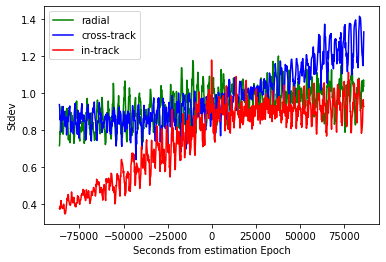

In [180]:
r_std = tr.extract_std_from_error_distributions(r_err_collection)
i_std = tr.extract_std_from_error_distributions(i_err_collection)
c_std = tr.extract_std_from_error_distributions(c_err_collection)

plt.plot(Ep_Offset_list[0],r_std,"g",label="radial")
plt.plot(Ep_Offset_list[0],c_std,"b",label="cross-track")
plt.plot(Ep_Offset_list[0],i_std,"r",label="in-track")
plt.xlabel("Seconds from estimation Epoch")
plt.ylabel("Stdev")
plt.legend()
plt.show()